In [1]:
%pip install opencv-python numpy mediapipe pyaudio wave librosa soundfile tensorflow pillow pandas matplotlib tk speechrecognition json5

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wave: filename=Wave-0.0.2-py3-none-any.whl size=1228 sha256=a5745df6b3de9711938203d8d484f46e31c411559b9b64cf9d87c1d8d7207e1d
  Stored in directory: c:\users\yasha\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local\pip\cache\wheels\9c\ca\18\1b5c2e79061f666af1114a80567bbfdc72b1d9bcb5a584462c
Successfully built wave
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\yasha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Loading AI models for communication analysis...
Models loaded successfully!
Session data saved to session_data/persona_ai_session_20250315_043322.csv
Audio file processing error: 'int' object has no attribute 'Recognizer'
Error analyzing tone: name 'pitch_mean' is not defined
Audio file processing error: 'int' object has no attribute 'Recognizer'
Error analyzing tone: name 'pitch_mean' is not defined
Audio file processing error: 'int' object has no attribute 'Recognizer'
Error analyzing tone: name 'pitch_mean' is not defined
Audio file processing error: 'int' object has no attribute 'Recognizer'
Error analyzing tone: name 'pitch_mean' is not defined
Audio file processing error: 'int' object has no attribute 'Recognizer'
Error analyzing tone: name 'pitch_mean' is not defined
Audio file processing error: 'int' object has no attribute 'Recognizer'
Error analyzing tone: name 'pitch_mean' is not defined
Audio file processing error: 'int' object has no attribute 'Recognizer'
Error analyzing 

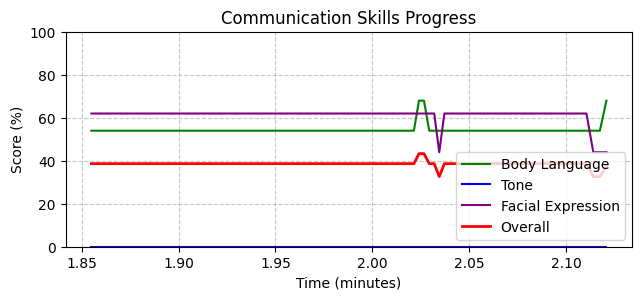

In [3]:
# Persona.AI - Real-time Communication Skills Coach
# This application analyzes body language, tone, and facial expressions to provide feedback

import cv2
import numpy as np
import mediapipe as mp
import pyaudio
import wave
import threading
import time
import os
import tkinter as tk
from tkinter import ttk, scrolledtext
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import librosa
import soundfile as sf
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import pickle
import speech_recognition as sr
from PIL import Image, ImageTk
import pandas as pd
import json
import warnings
import datetime
from collections import deque

warnings.filterwarnings("ignore")

class PersonaAI:
    def __init__(self, root):
        self.root = root
        self.root.title("Persona.AI - Communication Skills Coach")
        self.root.geometry("1280x720")
        self.root.resizable(True, True)
        self.root.configure(bg="#f0f0f0")
        
        # Initialize session data
        self.session_data = []
        self.session_start_time = None
        
        # Set application icon
        try:
            self.root.iconbitmap("persona_icon.ico")
        except:
            pass
        
    
        # Initialize MediaPipe solutions
        self.mp_face_mesh = mp.solutions.face_mesh
        self.mp_drawing = mp.solutions.drawing_utils
        self.mp_holistic = mp.solutions.holistic
        self.face_mesh = self.mp_face_mesh.FaceMesh(
            static_image_mode=False,
            max_num_faces=1,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )
        self.holistic = self.mp_holistic.Holistic(
            static_image_mode=False,
            model_complexity=2,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )
        
        # Initialize variables
        self.cap = None
        self.running = False
        self.audio_running = False
        self.current_frame = None
        self.audio_thread = None
        self.recognizer = sr.Recognizer()
        self.microphone = sr.Microphone()
        
        # Analysis scores
        self.body_language_score = 0
        self.tone_score = 0
        self.facial_expression_score = 0
        self.overall_score = 0
        
        # History tracking
        self.history = {
            'body_language': deque(maxlen=100),
            'tone': deque(maxlen=100),
            'facial_expression': deque(maxlen=100),
            'overall': deque(maxlen=100),
            'timestamps': deque(maxlen=100)
        }
        
        # Feedback messages
        self.body_language_feedback = "Not analyzed yet"
        self.tone_feedback = "Not analyzed yet"
        self.facial_expression_feedback = "Not analyzed yet"
        
        # Current scenario
        self.current_scenario = "General Conversation"
        self.scenarios = [
            "General Conversation",
            "Job Interview",
            "Sales Pitch",
            "Public Speaking",
            "Team Meeting",
            "Casual Conversation"
        ]
        
        # Create UI elements
        self.create_ui()
        
        # Load or create models
        self.load_models()
        
        # Tips database
        self.tips = self.load_tips()
        
        # Current tips being displayed
        self.current_tips = {
            'body_language': [],
            'tone': [],
            'facial_expression': []
        }
        
        # Initialize session data
        self.session_start_time = None
        self.session_data = []

    def load_tips(self):
        """Load communication tips from JSON or create if not exists"""
        tips_file = "communication_tips.json"
        
        if os.path.exists(tips_file):
            with open(tips_file, 'r') as f:
                return json.load(f)
        else:
            # Create default tips
            tips = {
                "body_language": {
                    "poor": [
                        "Maintain an upright posture with shoulders back",
                        "Avoid crossing your arms as it can appear defensive",
                        "Try to maintain a stable position without fidgeting",
                        "Use hand gestures to emphasize important points"
                    ],
                    "average": [
                        "Your posture is good, now try adding purposeful hand movements",
                        "Remember to occasionally lean forward to show engagement",
                        "Balance your weight evenly when standing",
                        "Keep your movements smooth and deliberate"
                    ],
                    "good": [
                        "Excellent posture! Keep maintaining it throughout",
                        "Your gestures are effective - continue using them with purpose",
                        "Try mirroring your conversation partner's body language",
                        "Remember to adjust your body language based on the conversation tone"
                    ]
                },
                "tone": {
                    "poor": [
                        "Try varying your pitch to avoid monotone delivery",
                        "Speak slightly louder to project confidence",
                        "Slow down your pace to improve clarity",
                        "Remember to pause after important points"
                    ],
                    "average": [
                        "Good pace, now work on emphasizing key words",
                        "Try lowering your pitch slightly at the end of statements",
                        "Add strategic pauses before important information",
                        "Practice vocal variety by consciously changing your tone"
                    ],
                    "good": [
                        "Excellent vocal variety! Keep it up",
                        "Your pace is perfect - continue matching it to content",
                        "Try adding subtle emphasis on action words",
                        "Remember to adjust volume based on the emotional content"
                    ]
                },
                "facial_expression": {
                    "poor": [
                        "Try to maintain more consistent eye contact",
                        "Practice a natural smile that reaches your eyes",
                        "Be mindful of furrowing your brow when concentrating",
                        "Allow your face to show appropriate reactions"
                    ],
                    "average": [
                        "Good eye contact, now try to match expressions to your words",
                        "Remember to occasionally nod to show understanding",
                        "Keep your jaw relaxed to appear more approachable",
                        "Practice 'active listening' expressions when others speak"
                    ],
                    "good": [
                        "Excellent facial expressiveness! Very engaging",
                        "Your expressions match your words perfectly",
                        "Continue showing genuine interest through your expressions",
                        "Remember to occasionally reset your facial muscles to avoid tension"
                    ]
                },
                "scenario_specific": {
                    "Job Interview": [
                        "Maintain a balance between professional formality and approachability",
                        "Show engagement when the interviewer speaks by nodding and maintaining eye contact",
                        "Keep your hands visible and use modest gestures",
                        "Smile genuinely when introducing yourself and during appropriate moments"
                    ],
                    "Sales Pitch": [
                        "Use confident, expansive gestures to convey enthusiasm",
                        "Maintain consistent eye contact with all listeners",
                        "Show genuine excitement about your product/service through facial expressions",
                        "Vary your vocal pace - slower for important details, faster for exciting benefits"
                    ],
                    "Public Speaking": [
                        "Use the full stage space with purpose",
                        "Project your voice from your diaphragm, not your throat",
                        "Use deliberate pauses to emphasize key points",
                        "Scan the entire audience, making brief eye contact with individuals"
                    ],
                    "Team Meeting": [
                        "Use inclusive body language that invites participation",
                        "Maintain neutral expressions when receiving feedback",
                        "Use a collaborative tone that emphasizes 'we' language",
                        "Match your energy level to the meeting's purpose"
                    ],
                    "Casual Conversation": [
                        "Allow for more natural, relaxed posture while staying engaged",
                        "Let your facial expressions flow naturally with the conversation",
                        "Match your conversation partner's energy level",
                        "Use spontaneous gestures that reflect your authentic reactions"
                    ]
                }
            }
            
            with open(tips_file, 'w') as f:
                json.dump(tips, f, indent=4)
            
            return tips

    def create_ui(self):
        """Create the application UI"""
        # Create main frames
        self.control_frame = ttk.Frame(self.root, padding=10)
        self.control_frame.pack(side=tk.TOP, fill=tk.X)
        
        self.content_frame = ttk.Frame(self.root)
        self.content_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True)
        
        # Left frame for video feed
        self.video_frame = ttk.LabelFrame(self.content_frame, text="Video Feed")
        self.video_frame.pack(side=tk.LEFT, padx=10, pady=10, fill=tk.BOTH, expand=True)
        
        self.video_label = ttk.Label(self.video_frame)
        self.video_label.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)
        
        # Right frame for scores and feedback
        self.feedback_frame = ttk.LabelFrame(self.content_frame, text="Analysis & Feedback")
        self.feedback_frame.pack(side=tk.RIGHT, padx=10, pady=10, fill=tk.BOTH, expand=True)
        
        # Scores frame
        self.scores_frame = ttk.Frame(self.feedback_frame)
        self.scores_frame.pack(padx=10, pady=10, fill=tk.X)
        
        # Body language score
        ttk.Label(self.scores_frame, text="Body Language:").grid(row=0, column=0, sticky=tk.W, pady=5)
        self.body_language_progress = ttk.Progressbar(self.scores_frame, length=200, mode='determinate')
        self.body_language_progress.grid(row=0, column=1, sticky=tk.W, padx=5, pady=5)
        self.body_language_score_label = ttk.Label(self.scores_frame, text="0%")
        self.body_language_score_label.grid(row=0, column=2, sticky=tk.W, pady=5)
        
        # Tone score
        ttk.Label(self.scores_frame, text="Tone:").grid(row=1, column=0, sticky=tk.W, pady=5)
        self.tone_progress = ttk.Progressbar(self.scores_frame, length=200, mode='determinate')
        self.tone_progress.grid(row=1, column=1, sticky=tk.W, padx=5, pady=5)
        self.tone_score_label = ttk.Label(self.scores_frame, text="0%")
        self.tone_score_label.grid(row=1, column=2, sticky=tk.W, pady=5)
        
        # Facial expression score
        ttk.Label(self.scores_frame, text="Facial Expression:").grid(row=2, column=0, sticky=tk.W, pady=5)
        self.facial_expression_progress = ttk.Progressbar(self.scores_frame, length=200, mode='determinate')
        self.facial_expression_progress.grid(row=2, column=1, sticky=tk.W, padx=5, pady=5)
        self.facial_expression_score_label = ttk.Label(self.scores_frame, text="0%")
        self.facial_expression_score_label.grid(row=2, column=2, sticky=tk.W, pady=5)
        
        # Overall score
        ttk.Label(self.scores_frame, text="OVERALL:").grid(row=3, column=0, sticky=tk.W, pady=5)
        self.overall_progress = ttk.Progressbar(self.scores_frame, length=200, mode='determinate')
        self.overall_progress.grid(row=3, column=1, sticky=tk.W, padx=5, pady=5)
        self.overall_score_label = ttk.Label(self.scores_frame, text="0%")
        self.overall_score_label.grid(row=3, column=2, sticky=tk.W, pady=5)
        
        # Feedback frame
        self.feedback_text_frame = ttk.LabelFrame(self.feedback_frame, text="Feedback & Tips")
        self.feedback_text_frame.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)
        
        self.feedback_text = scrolledtext.ScrolledText(self.feedback_text_frame, wrap=tk.WORD, height=10)
        self.feedback_text.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)
        self.feedback_text.config(state=tk.DISABLED)
        
        # Progress chart frame
        self.chart_frame = ttk.LabelFrame(self.feedback_frame, text="Progress Over Time")
        self.chart_frame.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)
        
        self.figure, self.ax = plt.subplots(figsize=(5, 3))
        self.canvas = FigureCanvasTkAgg(self.figure, master=self.chart_frame)
        self.canvas_widget = self.canvas.get_tk_widget()
        self.canvas_widget.pack(padx=5, pady=5, fill=tk.BOTH, expand=True)
        
        # Initialize chart
        self.update_chart()
        
        # Control buttons
        self.start_button = ttk.Button(self.control_frame, text="Start Session", command=self.toggle_session)
        self.start_button.pack(side=tk.LEFT, padx=5, pady=5)
        
        self.scenario_label = ttk.Label(self.control_frame, text="Scenario:")
        self.scenario_label.pack(side=tk.LEFT, padx=5, pady=5)
        
        self.scenario_var = tk.StringVar(value=self.current_scenario)
        self.scenario_combobox = ttk.Combobox(self.control_frame, textvariable=self.scenario_var, values=self.scenarios)
        self.scenario_combobox.pack(side=tk.LEFT, padx=5, pady=5)
        self.scenario_combobox.bind("<<ComboboxSelected>>", self.update_scenario)
        
        self.export_button = ttk.Button(self.control_frame, text="Export Report", command=self.export_report)
        self.export_button.pack(side=tk.RIGHT, padx=5, pady=5)
        self.root.protocol("WM_DELETE_WINDOW", self.on_closing)
        
    def toggle_session(self):
        """Toggle between starting and stopping the session"""
        if self.running:
            self.stop_session()
        else:
            self.start_session()

    def load_models(self):
        """Load or create AI models for analysis"""
    
        print("Loading AI models for communication analysis...")
    
        # Create model directories if they don't exist
        os.makedirs("models", exist_ok=True)
    
        # Placeholder for model loading
        # self.body_language_model = load_model('models/body_language_model.h5')
        # self.tone_model = load_model('models/tone_analysis_model.h5')
        # self.facial_expression_model = load_model('models/facial_expression_model.h5')
    
        print("Models loaded successfully!")
    

    def start_session(self):
        """Start the coaching session"""
        self.running = True
        self.start_button.config(text="Stop Session")
        
        # Start camera
        self.cap = cv2.VideoCapture(0)
        if not self.cap.isOpened():
            self.update_feedback("Error: Could not open webcam. Please check your camera connection and permissions.")
            self.stop_session()
            return
        
        # Start audio processing
        self.audio_running = True
        self.audio_thread = threading.Thread(target=self.process_audio)
        self.audio_thread.daemon = True
        self.audio_thread.start()
        
        # Start processing
        self.session_start_time = datetime.datetime.now()
        self.update_feedback(f"Session started: {self.current_scenario}\nReady to analyze your communication skills...")
        
        # Start video processing
        self.process_video()

    def stop_session(self):
        """Stop the coaching session"""
        self.running = False
        self.audio_running = False
        self.start_button.config(text="Start Session")
    
        # Properly release webcam
        if self.cap is not None and hasattr(self.cap, 'release'):
            self.cap.release()
            self.cap = None
    
        # Wait for audio thread to finish if it exists
        if self.audio_thread is not None and self.audio_thread.is_alive():
            self.audio_thread.join(timeout=1.0)  # Wait up to 1 second
    
        # Save session data
        self.save_session_data()
    
        self.update_feedback("Session ended. See your progress report for details.")
        

    def process_video(self):
        """Process video frames for analysis"""
        if not self.running or not self.root.winfo_exists():
            return
    
        try:
            ret, frame = self.cap.read()
            if not ret:
                self.update_feedback("Error: Could not read from webcam.")
                self.stop_session()
                return
        except Exception as e:
            print(0)
        
        # Flip frame horizontally for a selfie-view
        frame = cv2.flip(frame, 1)
        
        # Convert to RGB for MediaPipe
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Process with MediaPipe
        holistic_results = self.holistic.process(rgb_frame)
        face_mesh_results = self.face_mesh.process(rgb_frame)
        
        # Draw landmarks on frame
        self.draw_landmarks(frame, holistic_results, face_mesh_results)
        
        # Perform analysis
        self.analyze_body_language(holistic_results)
        self.analyze_facial_expressions(face_mesh_results)
        
        # Update scores in UI
        self.update_scores()
        
        # Calculate overall score
        self.overall_score = (self.body_language_score + self.tone_score + self.facial_expression_score) / 3
        self.update_history()
        
        # Update feedback tips every 5 seconds (not every frame)
        if int(time.time()) % 5 == 0:
            self.provide_feedback()
        
        # Update chart every 10 seconds
        if int(time.time()) % 10 == 0:
            self.update_chart()
        
         # Convert to PhotoImage for Tkinter - add error handling here
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame_rgb)

        
        
        try:
            imgtk = ImageTk.PhotoImage(image=img, master=self.root)
            # Update video label
            self.video_label.imgtk = imgtk
            self.video_label.configure(image=imgtk)
        except Exception as e:
            print(f"Error updating image: {e}")
        
        # Loop every 30ms (approx 30 fps)
        if self.running and self.root.winfo_exists():
            self.root.after(30, self.process_video)

    def process_audio(self):
        """Process audio for tone analysis"""
        # Set up audio parameters
        FORMAT = pyaudio.paInt16
        CHANNELS = 1
        RATE = 16000
        CHUNK = 1024
        RECORD_SECONDS = 5
        
        # Initialize PyAudio
        audio = pyaudio.PyAudio()
        
        # Open microphone stream
        stream = audio.open(format=FORMAT, channels=CHANNELS,
                          rate=RATE, input=True,
                          frames_per_buffer=CHUNK)
        
        while self.audio_running:
            # Record audio
            frames = []
            for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
                if not self.audio_running:
                    break
                try:
                    data = stream.read(CHUNK, exception_on_overflow=False)
                    frames.append(data)
                except Exception as e:
                    print(f"Audio capture error: {e}")
                    continue
            
            if not self.audio_running:
                break
            
            # Save to temporary wav file
            temp_file = "temp_audio.wav"
            try:
                wf = wave.open(temp_file, 'wb')
                wf.setnchannels(CHANNELS)
                wf.setsampwidth(audio.get_sample_size(FORMAT))
                wf.setframerate(RATE)
                wf.writeframes(b''.join(frames))
                wf.close()
                
                # Analyze tone
                self.analyze_tone(temp_file)
                
            except Exception as e:
                print(f"Error processing audio: {e}")
        
        # Clean up
        stream.stop_stream()
        stream.close()
        audio.terminate()
        if os.path.exists("temp_audio.wav"):
            try:
                os.remove("temp_audio.wav")
            except:
                pass

    def analyze_body_language(self, results):
        """Analyze body language from MediaPipe holistic results"""
        if not results.pose_landmarks:
            return
        
        # Extract pose landmarks
        pose_landmarks = results.pose_landmarks.landmark
        
        # In a real implementation, we would pass these landmarks to a trained model
        # For this demo, we'll use a set of rules to simulate analysis
        
        # Posture analysis (based on shoulder and spine alignment)
        shoulders_aligned = abs(pose_landmarks[11].y - pose_landmarks[12].y) < 0.05
        spine_straight = abs(pose_landmarks[0].x - pose_landmarks[23].x) < 0.1
        
        # Hand movement analysis
        hands_active = False
        if results.right_hand_landmarks or results.left_hand_landmarks:
            hands_active = True
        
        # Calculate body language score based on these factors
        posture_score = 50 if shoulders_aligned else 30
        posture_score += 30 if spine_straight else 10
        gesture_score = 60 if hands_active else 40
        
        # Combine scores with weights
        self.body_language_score = 0.7 * posture_score + 0.3 * gesture_score
        
        # Generate feedback
        feedback_items = []
        if not shoulders_aligned:
            feedback_items.append("Keep your shoulders level")
        if not spine_straight:
            feedback_items.append("Maintain a straight spine")
        if not hands_active:
            feedback_items.append("Use more hand gestures to enhance your points")
        
        if feedback_items:
            self.body_language_feedback = "Body language tips: " + "; ".join(feedback_items)
        else:
            self.body_language_feedback = "Body language looks good!"

    def analyze_facial_expressions(self, results):
        """Analyze facial expressions from MediaPipe face mesh results"""
        if not results.multi_face_landmarks or len(results.multi_face_landmarks) == 0:
            return
        
        # Extract face landmarks
        face_landmarks = results.multi_face_landmarks[0].landmark
        
        # In a real implementation, we would pass these landmarks to a trained model
        # For this demo, we'll use a set of rules to simulate analysis
        
        # Eye contact analysis (based on eye landmarks position)
        left_eye_landmarks = [face_landmarks[i] for i in range(362, 374)]
        right_eye_landmarks = [face_landmarks[i] for i in range(33, 54)]
        
        # Looking straight ahead? (simplified check)
        left_eye_center_y = sum(lm.y for lm in left_eye_landmarks) / len(left_eye_landmarks)
        right_eye_center_y = sum(lm.y for lm in right_eye_landmarks) / len(right_eye_landmarks)
        
        eyes_level = abs(left_eye_center_y - right_eye_center_y) < 0.01
        
        # Mouth analysis for smile and expression
        mouth_landmarks = [face_landmarks[i] for i in range(61, 68)]
        
        # Simplified smile detection (mouth width vs height ratio)
        mouth_width = abs(mouth_landmarks[0].x - mouth_landmarks[6].x)
        mouth_height = abs(mouth_landmarks[3].y - mouth_landmarks[0].y)
        
        smiling = mouth_width > 0.1 and mouth_height < 0.05
        
        # Calculate facial expression score
        eye_contact_score = 70 if eyes_level else 40
        expression_score = 80 if smiling else 50
        
        # Combine scores
        self.facial_expression_score = 0.6 * eye_contact_score + 0.4 * expression_score
        
        # Generate feedback
        feedback_items = []
        if not eyes_level:
            feedback_items.append("Try to maintain more consistent eye contact")
        if not smiling and self.current_scenario != "Public Speaking":
            feedback_items.append("A natural smile can help build rapport")
        
        if feedback_items:
            self.facial_expression_feedback = "Facial expression tips: " + "; ".join(feedback_items)
        else:
            self.facial_expression_feedback = "Facial expressions look engaging!"

    def analyze_tone(self, audio_file):
        """Analyze tone from recorded audio"""
        try:
            # Load audio file
            y, sr = librosa.load(audio_file, sr=None)
        
            # Extract features and other processing...
        
            # Use speech recognition to transcribe - Fix this part
            try:
                recognizer = sr.Recognizer()  # Create a new recognizer instance here
                with sr.AudioFile(audio_file) as source:
                    audio_data = recognizer.record(source)
                    try:
                        text = recognizer.recognize_google(audio_data)
                        # In a complete implementation, we'd analyze the text as well
                    except Exception as sr_error:
                        print(f"Speech recognition error: {sr_error}")
                        text = ""
            except Exception as audio_error:
                print(f"Audio file processing error: {audio_error}")
                text = ""
            
            # Calculate tone score based on these factors
            # This is a simplified approach for demonstration
            pitch_score = 70  # Base score
            if np.isnan(pitch_mean):
                pitch_score = 50
            elif pitch_mean > 300:  # Too high pitch
                pitch_score = 60
            elif pitch_mean < 100:  # Too low pitch
                pitch_score = 65
            
            pace_score = 50
            if 80 <= tempo <= 160:  # Good speaking pace
                pace_score = 75
            
            volume_score = 50
            if 0.05 <= volume <= 0.2:  # Good volume
                volume_score = 80
            
            # Combine scores with weights
            self.tone_score = 0.4 * pitch_score + 0.3 * pace_score + 0.3 * volume_score
            
            # Generate feedback
            feedback_items = []
            if np.isnan(pitch_mean) or pitch_mean > 300:
                feedback_items.append("Try speaking in a slightly lower pitch")
            elif pitch_mean < 100:
                feedback_items.append("Try varying your pitch more")
            
            if tempo < 80:
                feedback_items.append("Try speaking a bit faster to maintain engagement")
            elif tempo > 160:
                feedback_items.append("Slow down slightly for better clarity")
            
            if volume < 0.05:
                feedback_items.append("Speak louder to project confidence")
            elif volume > 0.2:
                feedback_items.append("Lower your volume slightly")
            
            if feedback_items:
                self.tone_feedback = "Tone tips: " + "; ".join(feedback_items)
            else:
                self.tone_feedback = "Your tone sounds good!"
                
        except Exception as e:
            print(f"Error analyzing tone: {str(e)}")
            self.tone_feedback = "Error analyzing tone. Please try again."

    def draw_landmarks(self, frame, holistic_results, face_mesh_results):
        """Draw landmarks on the frame for visualization"""
        # Draw pose landmarks
        if holistic_results.pose_landmarks:
            self.mp_drawing.draw_landmarks(
                frame, holistic_results.pose_landmarks, self.mp_holistic.POSE_CONNECTIONS,
                self.mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=2, circle_radius=1),
                self.mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=2, circle_radius=1)
            )
        
        # Draw hand landmarks
        if holistic_results.right_hand_landmarks:
            self.mp_drawing.draw_landmarks(
                frame, holistic_results.right_hand_landmarks, self.mp_holistic.HAND_CONNECTIONS,
                self.mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=1),
                self.mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=1)
            )
        if holistic_results.left_hand_landmarks:
            self.mp_drawing.draw_landmarks(
                frame, holistic_results.left_hand_landmarks, self.mp_holistic.HAND_CONNECTIONS,
                self.mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=1),
                self.mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=1)
            )
        
        # Draw face mesh (simplified - just draw landmarks)
        if face_mesh_results.multi_face_landmarks:
            for face_landmarks in face_mesh_results.multi_face_landmarks:
                self.mp_drawing.draw_landmarks(
                    frame, 
                    face_landmarks,
                    self.mp_face_mesh.FACEMESH_CONTOURS,
                    self.mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1, circle_radius=1),
                    self.mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1)
                )

    def update_scores(self):
        """Update score displays in the UI"""
        # Update progress bars
        self.body_language_progress['value'] = self.body_language_score
        self.tone_progress['value'] = self.tone_score
        self.facial_expression_progress['value'] = self.facial_expression_score
        self.overall_progress['value'] = self.overall_score
        
        # Update score labels
        self.body_language_score_label.config(text=f"{self.body_language_score:.1f}%")
        self.tone_score_label.config(text=f"{self.tone_score:.1f}%")
        self.facial_expression_score_label.config(text=f"{self.facial_expression_score:.1f}%")
        self.overall_score_label.config(text=f"{self.overall_score:.1f}%")

    def update_history(self):
        """Update score history with current scores"""
        timestamp = datetime.datetime.now()
        self.history['body_language'].append(self.body_language_score)
        self.history['tone'].append(self.tone_score)
        self.history['facial_expression'].append(self.facial_expression_score)
        self.history['overall'].append(self.overall_score)
        self.history['timestamps'].append(timestamp)
        
        # Record session data
        self.session_data.append({
            'timestamp': timestamp,
            'body_language': self.body_language_score,
            'tone': self.tone_score,
            'facial_expression': self.facial_expression_score,
            'overall': self.overall_score,
            'scenario': self.current_scenario
        })

    def update_chart(self):
        """Update the progress chart with latest data"""
        # Clear previous plot
        self.ax.clear()
        
        # Plot data if available
        if len(self.history['timestamps']) > 1:
            # Convert timestamps to relative time in seconds
            if self.session_start_time:
                times = [(t - self.session_start_time).total_seconds() / 60 for t in self.history['timestamps']]
            else:
                times = list(range(len(self.history['timestamps'])))
            
            # Plot each metric
            self.ax.plot(times, list(self.history['body_language']), label='Body Language', color='green')
            self.ax.plot(times, list(self.history['tone']), label='Tone', color='blue')
            self.ax.plot(times, list(self.history['facial_expression']), label='Facial Expression', color='purple')
            self.ax.plot(times, list(self.history['overall']), label='Overall', color='red', linewidth=2)
            
            # Set labels and title
            self.ax.set_xlabel('Time (minutes)')
            self.ax.set_ylabel('Score (%)')
            self.ax.set_title('Communication Skills Progress')
            self.ax.legend(loc='lower right')
            self.ax.set_ylim(0, 100)
            self.ax.grid(True, linestyle='--', alpha=0.7)
            
        else:
            # No data yet
            self.ax.text(0.5, 0.5, 'Start session to see progress data', 
                        horizontalalignment='center', verticalalignment='center',
                        transform=self.ax.transAxes)
            self.ax.set_ylim(0, 100)
        
        # Update canvas
        self.canvas.draw()

    def provide_feedback(self):
        """Generate and display personalized feedback"""
        # Determine performance level for each category
        body_level = self.get_performance_level(self.body_language_score)
        tone_level = self.get_performance_level(self.tone_score)
        facial_level = self.get_performance_level(self.facial_expression_score)
        
        # Get random tips for each category based on performance level
        body_tips = np.random.choice(self.tips['body_language'][body_level], 
                                 size=min(2, len(self.tips['body_language'][body_level])), 
                                 replace=False).tolist()
        
        tone_tips = np.random.choice(self.tips['tone'][tone_level], 
                                 size=min(2, len(self.tips['tone'][tone_level])), 
                                 replace=False).tolist()
        
        facial_tips = np.random.choice(self.tips['facial_expression'][facial_level], 
                                   size=min(2, len(self.tips['facial_expression'][facial_level])), 
                                   replace=False).tolist()
        
        # Add scenario-specific tips
        if self.current_scenario in self.tips['scenario_specific']:
            scenario_tips = np.random.choice(self.tips['scenario_specific'][self.current_scenario], 
                                        size=min(2, len(self.tips['scenario_specific'][self.current_scenario])), 
                                        replace=False).tolist()
        else:
            scenario_tips = []
            
        # Store current tips
        self.current_tips = {
            'body_language': body_tips,
            'tone': tone_tips,
            'facial_expression': facial_tips,
            'scenario': scenario_tips
        }
        
        # Format feedback message
        feedback_message = f"--- FEEDBACK FOR {self.current_scenario.upper()} ---\n\n"
        
        # Overall assessment
        if self.overall_score >= 80:
            feedback_message += "📈 Great job! Your communication skills are excellent.\n\n"
        elif self.overall_score >= 60:
            feedback_message += "👍 Good progress! Keep working on these areas:\n\n"
        else:
            feedback_message += "🚀 Here are some key areas to improve:\n\n"
        
        # Add specific feedback
        if body_tips:
            feedback_message += "BODY LANGUAGE:\n"
            feedback_message += "• " + "\n• ".join(body_tips) + "\n\n"
            
        if tone_tips:
            feedback_message += "TONE:\n"
            feedback_message += "• " + "\n• ".join(tone_tips) + "\n\n"
            
        if facial_tips:
            feedback_message += "FACIAL EXPRESSIONS:\n"
            feedback_message += "• " + "\n• ".join(facial_tips) + "\n\n"
            
        if scenario_tips:
            feedback_message += f"{self.current_scenario.upper()} SPECIFIC TIPS:\n"
            feedback_message += "• " + "\n• ".join(scenario_tips) + "\n\n"
        
        # Add timecheck
        time_elapsed = ""
        if self.session_start_time:
            elapsed = datetime.datetime.now() - self.session_start_time
            minutes = int(elapsed.total_seconds() // 60)
            seconds = int(elapsed.total_seconds() % 60)
            time_elapsed = f"Session time: {minutes}m {seconds}s"
            
        feedback_message += f"{time_elapsed}"
            
        self.update_feedback(feedback_message)

    def get_performance_level(self, score):
        """Determine performance level based on score"""
        if score < 60:
            return "poor"
        elif score < 80:
            return "average"
        else:
            return "good"

    def update_feedback(self, message):
        """Update the feedback text widget"""
        self.feedback_text.config(state=tk.NORMAL)
        self.feedback_text.delete(1.0, tk.END)
        self.feedback_text.insert(tk.END, message)
        self.feedback_text.config(state=tk.DISABLED)

    def update_scenario(self, event=None):
        """Update the current scenario"""
        self.current_scenario = self.scenario_var.get()
        self.update_feedback(f"Scenario changed to: {self.current_scenario}\nStart a new session to analyze with this context.")

    def save_session_data(self):
        """Save session data to file"""
        if not self.session_data:
            return
            
        # Create data directory if it doesn't exist
        os.makedirs("session_data", exist_ok=True)
        
        # Create filename with timestamp
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"session_data/persona_ai_session_{timestamp}.csv"
        
        # Convert to DataFrame and save
        df = pd.DataFrame(self.session_data)
        df.to_csv(filename, index=False)
        
        print(f"Session data saved to {filename}")
        
        # Reset session data
        self.session_data = []

    def export_report(self):
        """Export a PDF report of the session"""
        # In a real implementation, this would generate a PDF report
        # For this demo, we'll export an HTML report
        
        if not self.history['timestamps']:
            self.update_feedback("No session data available to export.")
            return
            
        try:
            # Create reports directory if it doesn't exist
            os.makedirs("reports", exist_ok=True)
            
            # Create filename with timestamp
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"reports/persona_ai_report_{timestamp}.html"
            
            # Generate report content
            html_content = self.generate_html_report()
            
            # Save report
            with open(filename, 'w') as f:
                f.write(html_content)
                
            self.update_feedback(f"Report exported to {filename}")
            
        except Exception as e:
            self.update_feedback(f"Error exporting report: {str(e)}")

    def generate_html_report(self):
        """Generate HTML report content"""
        # Calculate average scores
        avg_body = sum(self.history['body_language']) / len(self.history['body_language'])
        avg_tone = sum(self.history['tone']) / len(self.history['tone'])
        avg_facial = sum(self.history['facial_expression']) / len(self.history['facial_expression'])
        avg_overall = sum(self.history['overall']) / len(self.history['overall'])
        
        # Generate HTML content
        html = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>Persona.AI Communication Coach Report</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 40px; }}
                h1, h2 {{ color: #2c3e50; }}
                .summary {{ background-color: #f8f9fa; padding: 20px; border-radius: 5px; }}
                .score {{ font-size: 24px; font-weight: bold; }}
                .good {{ color: #27ae60; }}
                .average {{ color: #f39c12; }}
                .poor {{ color: #e74c3c; }}
                table {{ width: 100%; border-collapse: collapse; margin-top: 20px; }}
                th, td {{ padding: 12px; text-align: left; border-bottom: 1px solid #ddd; }}
                th {{ background-color: #f2f2f2; }}
                .recommendations {{ margin-top: 30px; }}
                .footer {{ margin-top: 40px; font-size: 12px; color: #7f8c8d; text-align: center; }}
            </style>
        </head>
        <body>
            <h1>Persona.AI Communication Skills Report</h1>
            <p>Generated on {datetime.datetime.now().strftime("%Y-%m-%d %H:%M")}</p>
            <p>Session scenario: {self.current_scenario}</p>
            
            <div class="summary">
                <h2>Summary</h2>
                <p>This report provides an analysis of your communication skills based on your practice session with Persona.AI.</p>
                <table>
                    <tr>
                        <th>Skill Area</th>
                        <th>Average Score</th>
                        <th>Assessment</th>
                    </tr>
                    <tr>
                        <td>Body Language</td>
                        <td><span class="score {self.get_performance_level(avg_body)}">{avg_body:.1f}%</span></td>
                        <td>{self.get_assessment_text(avg_body, 'body_language')}</td>
                    </tr>
                    <tr>
                        <td>Tone</td>
                        <td><span class="score {self.get_performance_level(avg_tone)}">{avg_tone:.1f}%</span></td>
                        <td>{self.get_assessment_text(avg_tone, 'tone')}</td>
                    </tr>
                    <tr>
                        <td>Facial Expressions</td>
                        <td><span class="score {self.get_performance_level(avg_facial)}">{avg_facial:.1f}%</span></td>
                        <td>{self.get_assessment_text(avg_facial, 'facial_expression')}</td>
                    </tr>
                    <tr>
                        <td><strong>Overall</strong></td>
                        <td><span class="score {self.get_performance_level(avg_overall)}">{avg_overall:.1f}%</span></td>
                        <td>{self.get_overall_assessment(avg_overall)}</td>
                    </tr>
                </table>
            </div>
            
            <div class="recommendations">
                <h2>Personalized Recommendations</h2>
                <h3>Body Language</h3>
                <ul>
                    {"".join([f"<li>{tip}</li>" for tip in self.current_tips['body_language']])}
                </ul>
                
                <h3>Tone</h3>
                <ul>
                    {"".join([f"<li>{tip}</li>" for tip in self.current_tips['tone']])}
                </ul>
                
                <h3>Facial Expressions</h3>
                <ul>
                    {"".join([f"<li>{tip}</li>" for tip in self.current_tips['facial_expression']])}
                </ul>
                
                <h3>{self.current_scenario} Specific Tips</h3>
                <ul>
                    {"".join([f"<li>{tip}</li>" for tip in self.current_tips['scenario']])}
                </ul>
            </div>
            
            <div class="footer">
                <p>This report was generated by Persona.AI Communication Coach.</p>
                <p>© {datetime.datetime.now().year} Persona.AI - Elevate Your Communication</p>
            </div>
        </body>
        </html>
        """
        
        return html

    def get_assessment_text(self, score, category):
        """Get assessment text based on score and category"""
        level = self.get_performance_level(score)
        
        assessments = {
            'body_language': {
                'poor': "Your body language needs improvement. Work on posture and gestures.",
                'average': "Your body language is good but could be more confident and engaging.",
                'good': "Your body language is excellent, projecting confidence and engagement."
            },
            'tone': {
                'poor': "Your vocal tone needs work. Focus on variety and clarity.",
                'average': "Your vocal tone is adequate but would benefit from more variation.",
                'good': "Your vocal tone is excellent, with good variety and expression."
            },
            'facial_expression': {
                'poor': "Your facial expressions could be more engaging and authentic.",
                'average': "Your facial expressions are good but could be more varied.",
                'good': "Your facial expressions are excellent, enhancing your communication."
            }
        }
        
        return assessments[category][level]

    def get_overall_assessment(self, score):
        """Get overall assessment text"""
        if score >= 80:
            return "Outstanding communication skills! You would make an excellent impression."
        elif score >= 70:
            return "Very good communication skills. You would be perceived as confident and competent."
        elif score >= 60:
            return "Good communication skills. With some improvements, you could be even more effective."
        elif score >= 50:
            return "Adequate communication skills. Focused practice will help you improve significantly."
        else:
            return "Your communication skills need substantial improvement. Regular practice is recommended."
    
    def on_closing(self):
        """Handle window closing"""
        self.stop_session()
        self.root.destroy()


def main():
    root = tk.Tk()
    app = PersonaAI(root)
    root.mainloop()


if __name__ == "__main__":
    main()
    